# Playing with Minute-Market-Data
### Dan Schmidt's Script Fall 2016

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
from IPython.core.debugger import Tracer
import scipy as sp
import scipy.sparse 
import scipy.sparse.linalg
from sklearn.decomposition import PCA
from sklearn import cluster
%matplotlib inline

### Preprocessing
Read the data in, convert dates to a useful format, and dump it back out for faster hard drive reads later

In [2]:
data_loc = "C:\\Users\\Dan\\Documents\\mldata\\market_data\\"
# read in a symbols file, in this case rough SP500 sorted by 
symbols = [line.rstrip('\n') for line in open(data_loc+'symbols.txt')]

def get_symbol(symbol, start_date=None, end_date=None, daily=False):
    pickle_file = data_loc+symbol+'\\'+symbol+'.pkl'
    if os.path.isfile(pickle_file):
        print("Reading", symbol, "from pickle")
        df = pd.read_pickle(pickle_file)
    else:
        try:
            df = pd.read_csv(data_loc+symbol+'\\'+symbol+'.txt', dtype={'Time': object})
        except:
            print("failed to read in ",symbol)
            return None
        
    # Make a nice date time column
    #df['timestamp'] = df.apply(lambda x: pd.to_datetime(x['Date']+" "+x['Time'][:2]+':'+x['Time'][2:]), axis=1)
    if not os.path.isfile(pickle_file):
        df['timestamp'] = pd.to_datetime(df['Date']+" "+ df['Time'], format="%m/%d/%Y %H%M")
        df.set_index('timestamp', drop=False, inplace=True)
        df.drop(['Date', 'Time'], axis=1, inplace=True)
        print("Dumping", symbol, "to pickle")
        df.to_pickle(pickle_file)
    
    if start_date and end_date:
        return df[( (df['timestamp'] >= pd.to_datetime(start_date)) & (df['timestamp'] <= pd.to_datetime(end_date)))]
    else:
        return df
    
def get_symbols(syms, start_date, end_date, price='Open', daily=False):
    df = pd.DataFrame(columns=syms)
    for sym in syms:
        sym_df = get_symbol(sym, start_date, end_date)
        if not sym_df is None:
            df[sym] = sym_df[price]
            print(sym, "has been read in")
        else:
            df.drop(sym, axis=1, inplace=True)
    return df

cov_df = get_symbols(symbols, start_date="01/01/2015", end_date="12/31/2015")

Reading BAC from pickle
BAC has been read in
Reading CHK from pickle
CHK has been read in
Reading PG from pickle
PG has been read in
Reading WFC from pickle
WFC has been read in
Reading AAPL from pickle
AAPL has been read in
Reading GE from pickle
GE has been read in
Reading F from pickle
F has been read in
Reading MU from pickle
MU has been read in
Reading COTY from pickle
COTY has been read in
Reading FCX from pickle
FCX has been read in
Reading FTR from pickle
FTR has been read in
Reading MSFT from pickle
MSFT has been read in
Reading INTC from pickle
INTC has been read in
Reading T from pickle
T has been read in
Reading CSCO from pickle
CSCO has been read in
Reading PFE from pickle
PFE has been read in
Reading C from pickle
C has been read in
Reading RIG from pickle
RIG has been read in
Reading MRO from pickle
MRO has been read in
Reading KMI from pickle
KMI has been read in
Reading JPM from pickle
JPM has been read in
Reading RF from pickle
RF has been read in
Reading FB from pick

Reading AAPL from pickle


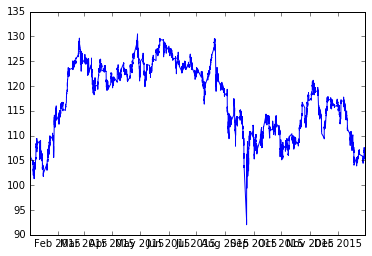

                Open          High           Low         Close        Volume  \
count   97530.000000  97530.000000  97530.000000  97530.000000  9.753000e+04   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
first            NaN           NaN           NaN           NaN           NaN   
last             NaN           NaN           NaN           NaN           NaN   
mean      117.212525    117.261454    117.160798    117.212077  1.129190e+05   
std         7.186291      7.177339      7.195252      7.186198  1.336346e+05   
min        92.030000     93.200000     90.080000     92.080000  4.220000e+03   
25%       111.110000    111.170000    111.050000    111.120000  5.044225e+04   
50%       118.150000    118.180000    118.110000    118.140000  8.159200e+04   
75%       123.460000    123.500000    12

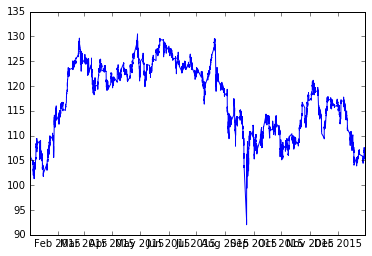

In [32]:
aapl = get_symbol('AAPL', start_date="01/01/2015", end_date="12/31/2015")
plt.plot(aapl['Open'])
plt.show()

print(aapl.describe(include="all"))

plt.plot(aapl['timestamp'], aapl['Open'])
plt.show()

   ### Process the data and filter out bad symbols/summarize missing dates

In [ ]:
def check_integrity(sym):
    

    
check_integrity(cov_df)

### Run SVD on time series

In [48]:
df = cov_df.transpose()

# Fill in missing prices
df.fillna(method='ffill', inplace=True)

returns = df.pct_change(axis=1)
returns.drop(labels=returns.columns[0], inplace=True, axis=1)

# Work in log return space, which has some nice properties
lreturns = np.log(1+returns.values)

X = lreturns
print(X.shape)

(500, 47969)


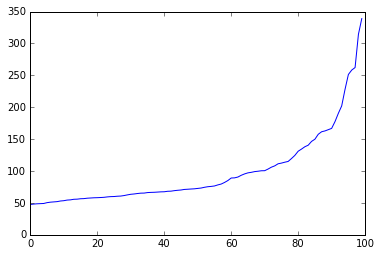

In [49]:
# SVD, only calculate top 100 
U, s, V = sp.sparse.linalg.svds(X, k=100, which='LM')

plt.plot(s)
plt.show()

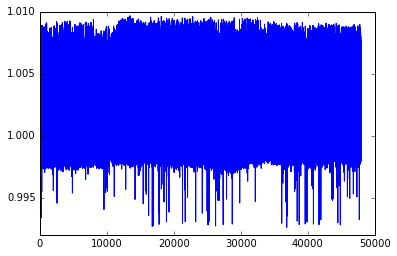

In [50]:

# Plot the principle component
pcomp = V[-1, :]
s = 100
plt.plot(np.exp(np.cumsum(pcomp)))
plt.show()

[[ 0.          0.         -0.01145488 ...,  0.          0.         -0.01941809]
 [ 0.          0.         -0.00417537 ...,  0.          0.          0.02058238]
 [ 0.          0.         -0.00666396 ...,  0.          0.         -0.00736845]
 ..., 
 [ 0.          0.         -0.01537528 ...,  0.          0.         -0.01115907]
 [ 0.          0.          0.54476807 ...,  0.          0.          0.35916689]
 [ 0.          0.          0.54476807 ...,  0.          0.         -0.01221155]]
[ 0.10002167  0.05827522  0.05271675  0.04990849  0.0420081   0.03891676
  0.03429468  0.03321958  0.03093577  0.02951753  0.02836132]


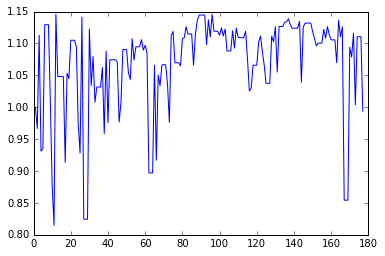

In [52]:
# Try downsampling to daily
daily_df = cov_df.resample('D').first().ffill()
daily_mat = daily_df.transpose()

returns = daily_mat.pct_change(axis=1)
returns.drop(labels=returns.columns[0], inplace=True, axis=1)

# Work in log return space, which has some nice properties
lreturns = np.log(1+returns.values)

X = lreturns
print(X)

pca = PCA(n_components=11, svd_solver='full')
pca.fit(X)
print(pca.explained_variance_ratio_) 


#U, s, V = np.linalg.svd(X)
plt.plot(np.exp(np.cumsum(pca.components_[0, :])))
plt.show()

#pcomp = V[0, :]
#plt.plot(np.exp(np.cumsum(pcomp)))
#plt.show()

In [60]:
# Spectral clustering

spectral = cluster.SpectralClustering(n_clusters=10,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
spectral.fit(X)
y_pred = spectral.labels_.astype(np.int)
for i in range(11):
    print("Cluster", i, " contains: ")
    for j in range(len(y_pred)):
        if (y_pred[j] == i):
            print(" ", symbols[j], end="")
    print(" ")

Cluster 0  contains: 
  COTY  SO  DVN  BK  GGP  CTL  YUM  MAS  SE  DG  IPG  AGN  MUR  UNP  GT  TJX  D  ADI  AMT  FIS  URBN  OI  K  ANTM  APH  LMT  STZ  GD  INTU  DPS  KSU  GOOG  OMC  HAS  NTRS  SLG  CTAS  RL  COL  MTB  JEC  FLIR  EQIX  EFX  FFIV  ICE  LH  FRT  LLL  SNA  PCLN  ROP  TDG  AIZ  ISRG 
Cluster 1  contains: 
  AAPL  GE  F  FCX  FTR  MSFT  T  CSCO  FB  BMY  KEY  KR  ORCL  YHOO  KO  CRM  GM  QCOM  NKE  FOXA  MRK  GILD  HPQ  NFLX  HST  GLW  AA  EBAY  WMT  SBUX  ATVI  CMCSA  SYMC  MYL  CTSH  XRX  CSX  SPLS  SYF  V  COG  NEM  PYPL  DIS  MDLZ  LUV  USB  WMB  AIG  GPS  ENDP  CVS  VLO  PPL  JCI  DOW  AES  MO  MAR  LOW  ABBV  CBS  M  VIAB  CCL  CAT  STX  HD  MOS  WFM  CF  UAL  APA  HES  HON  FE  NOV  PEP  TGT  AXP  RAI  PM  MDT  MCD  BAX  JNPR  UTX  IVZ  FTI  TWX  WBA  DISCA  CAG  WU  LLY  BHI  NWL  HBI  CELG  MAT  NAVI  IP  MON  FOX  ETFC  STI  UNH  CNP  GIS  LYB  DUK  AMZN  LVLT  BA  COH  ACN  LRCX  NBL  PGR  COF  DHR  LEN  ESRX  HIG  EQR  EOG  PEG  HCP  SWKS  KLAC  IBM  AEP  DFS  P

In [5]:
store = pd.HDFStore(data_loc+'test_store.h5')
store['cov_df'] = cov_df
store.close()